# Decision trees

We will work the the Titanic data set from kaggle:

https://www.kaggle.com/c/titanic


### Loading packages

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
%matplotlib inline

from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import pydotplus 

### Loading data

In [41]:
train = pd.read_csv('Titanic/train.csv')
train = train.dropna()
print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C103        S  


### Some feature engineering

Let's exclude the text features for the moment, because we will learn how to handle text features later. Text features here are Name and Ticket.

Features Sex, Embarked, and Cabin need to translated to numbers and maybe become categorical features. 

In [42]:
def word2letter(X_word):
    X_letter = []

    for x in X_word:
        X_letter.append(x[0])
    return X_letter
    
train['Cabin_letter'] = word2letter(train['Cabin'])

In [43]:
def text2number(X_word, words):
    numbers = range(len(words))
    
    X_number = X_word.copy()
    for n, w in zip(numbers, words):
        X_number[X_word == w] = n
    return X_number

embarked_words = list(set(train['Embarked']))
train['Embarked_number'] = text2number(train['Embarked'], embarked_words)

sex_words = list(set(train['Sex']))
train['Sex_number'] = text2number(train['Sex'], sex_words)

cabin_words = list(set(train['Cabin_letter']))
train['Cabin_number'] = text2number(train['Cabin_letter'], cabin_words)

print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked Cabin_letter Embarked_number  \
1       0  PC 17599  71.2833   C85        C            C               1   
3       0    113803  53.1000  C123        S            C               2   
6       0     17463  51.8625   E46        S            E               2   
10  

### Plot the features

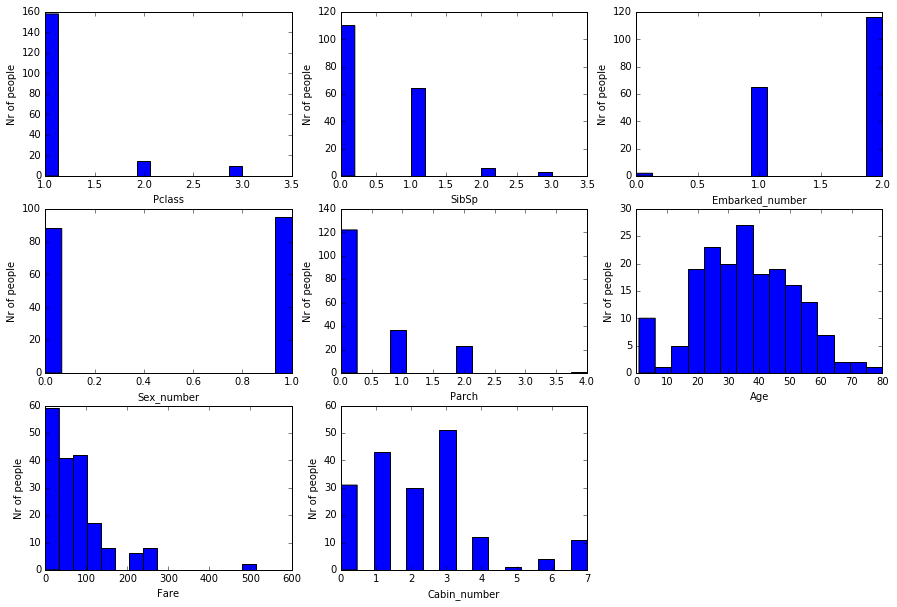

In [44]:
fig = plt.figure(figsize=(15, 10))

for idx, f in enumerate(['Pclass', 'SibSp','Embarked_number','Sex_number', 'Parch','Age','Fare','Cabin_number']):
    ax = fig.add_subplot(3,3,idx+1)
    ax.hist(train[f], 15)
    ax.set_xlabel(f)
    ax.set_ylabel('Nr of people')
    
plt.show()

Features are problematic, whose entries are numbers, but the value of the number has no meaning. These features pretend to have an order, where there is no. Features like this, we rebuild to categorical features. For each unique possible value, we build a new column which has entries 0 and 1.

In [59]:
## Make categorical features for Embarked
X_num = train['Embarked_number']
nmax = max(X_num)+1

for num in range(nmax):
    X_cat = np.zeros_like(X_num)
    for idx, entry in enumerate(X_num):
        if entry == num:
            X_cat[idx] = 1
    name = 'Embarked_' + str(num)
    train[name] = X_cat

## Make categorical features for Cabin
X_num = train['Cabin_number']
nmax = max(X_num)+1

for num in range(nmax):
    X_cat = np.zeros_like(X_num)
    for idx, entry in enumerate(X_num):
        if entry == num:
            X_cat[idx] = 1
    name = 'Cabin_' + str(num)
    train[name] = X_cat

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_1,Embarked_2,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,1,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,1,0,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,0,1,0,0,1,0,0,0,0,0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,...,0,1,0,0,0,0,0,0,1,0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,...,0,1,0,0,0,1,0,0,0,0


### Extract the features we want to use in the model

Now we extract all the features we want to use for training and get the train_labels.

In [60]:
## Features are translated to numbers
X = train[['Pclass', 'SibSp', 'Parch', 'Embarked_0', 'Embarked_1', 'Embarked_2','Sex_number', 'Age', 'Fare', 
           'Cabin_0', 'Cabin_1', 'Cabin_2', 'Cabin_3', 'Cabin_4', 'Cabin_5', 'Cabin_6', 'Cabin_7']].values
Y = train['Survived'].values        

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

M = X.shape[0]
M_train = int(M*0.8)

X_train = X[:M_train, :]
X_dev = X[M_train:, :]
Y_train = Y[:M_train]
Y_dev = Y[M_train:]

### Build a decision tree
Let's try to build a decision tree model.

In [61]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=10)
dt.fit(X_train, Y_train)
print('Accuracy (a decision tree):', dt.score(X_dev, Y_dev))


dot_data = export_graphviz(dt, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("tree.pdf") 

Accuracy (a decision tree): 0.756756756757


True

## Ensemble methods

### Random forest

Accuracy (a random forest): 0.783783783784
Accuracy (a random forest): 0.783783783784
Accuracy (a random forest): 0.756756756757
Accuracy (a random forest): 0.783783783784
Accuracy (a random forest): 0.810810810811
Accuracy (a random forest): 0.756756756757
Accuracy (a random forest): 0.810810810811
Accuracy (a random forest): 0.783783783784


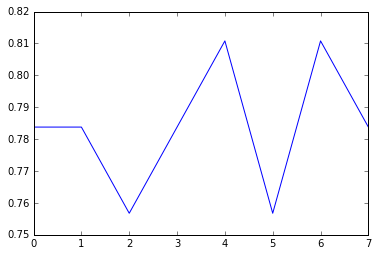

In [62]:
vec_acc = []
for num_est in [5,10,50,100, 500, 800, 1000, 1500]:
    rfc = RandomForestClassifier(criterion = "entropy", n_estimators=num_est)
    rfc.fit(X_train, Y_train)
    acc = rfc.score(X_dev, Y_dev)
    vec_acc.append(acc)
    print('Accuracy (a random forest):', rfc.score(X_dev, Y_dev))
plt.plot(vec_acc)

### More ensemble methods

Build a K-Nearest-Neighbor model

In [64]:
k_vec = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
acc_vec = []
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    #print('Accuracy for %i is %f' %(k, acc))
    
best_k = k_vec[np.argmax(acc_vec)]
print('Best k is: ', best_k, ' with accuracy ', max(acc_vec))

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, Y_train)
knn_preds = knn.predict(X_dev)

Best k is:  10  with accuracy  0.783783783784


Build a Logistic Regression model with L2-Regularization

In [65]:
c_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
acc_vec = []
for c in c_vec:
    lr2 = LogisticRegression(penalty='l2', C=c)
    lr2.fit(X_train, Y_train)
    preds = lr2.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    #print('Accuracy for %i is %f' %(c, acc))
    
best_c = c_vec[np.argmax(acc_vec)]
print('Best c is: ', best_c, ' with accuracy ', max(acc_vec))

lr2 = LogisticRegression(penalty='l2', C=best_c)
lr2.fit(X_train, Y_train)
lr2_preds = lr2.predict(X_dev)

Best c is:  1  with accuracy  0.945945945946


Build a Logistic Regression model with L1-Regularization

In [66]:
c_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
acc_vec = []
for c in c_vec:
    lr1 = LogisticRegression(penalty='l1', C=c)
    lr1.fit(X_train, Y_train)
    preds = lr1.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    #print('Accuracy for %i is %f' %(c, acc))
    
best_c = c_vec[np.argmax(acc_vec)]
print('Best c is: ', best_c, ' with accuracy ', max(acc_vec))

lr1 = LogisticRegression(penalty='l1', C=best_c)
lr1.fit(X_train, Y_train)
lr1_preds = lr1.predict(X_dev)

Best c is:  10  with accuracy  0.891891891892


Build a Decision Tree model 

In [67]:
d_vec = [1,3,5,7,9,11,13,15,17,19]
acc_vec = []
for d in d_vec:
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=d)
    dt.fit(X_train, Y_train)
    preds = dt.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    #print('Accuracy for %i is %f' %(d, acc))
    
best_d = d_vec[np.argmax(acc_vec)]
print('Best depth is: ', best_d, ' with accuracy ', max(acc_vec))

dt = DecisionTreeClassifier(criterion="entropy", max_depth=best_d)
dt.fit(X_train, Y_train)
dt_preds = lr1.predict(X_dev)

Best depth is:  1  with accuracy  0.837837837838


We take a vote using all predictions from the models

In [68]:
final_preds = []
for k, l2, l1, d in zip(knn_preds, lr2_preds, lr1_preds, dt_preds):
    final_preds.append(np.round((k+l2+l2+d) / 4))
acc = np.mean(final_preds == Y_dev)
print('The final accuracy is: ', acc)

The final accuracy is:  0.945945945946
